In [1]:
# pip3 install google-cloud-bigquery google-cloud-bigquery-storage pyarrow tqdm ipywidgets pandas matplotlib db-dtypes

In [7]:
from google.cloud import bigquery

In [3]:
bq = bigquery.Client()

In [10]:
for ds in bq.list_datasets("cs320-f21"):
    print(ds.dataset_id)

apr24
apr25
apr26
apr28
loans1
p7
test2


In [9]:
# NAME:
# project.dataset.table
dataset = bigquery.Dataset("cs320-f21.apr28")
# dataset.location = ...
bq.create_dataset(dataset, exists_ok=True)

Dataset(DatasetReference('cs320-f21', 'apr28'))

In [11]:
for ds in bq.list_datasets("bigquery-public-data"):
    print(ds.dataset_id)

america_health_rankings
austin_311
austin_bikeshare
austin_crime
austin_incidents
austin_waste
baseball
bitcoin_blockchain
blackhole_database
bls
bls_qcew
breathe
broadstreet_adi
catalonian_mobile_coverage
catalonian_mobile_coverage_eu
census_bureau_acs
census_bureau_construction
census_bureau_international
census_bureau_usa
census_opportunity_atlas
census_utility
cfpb_complaints
chicago_crime
chicago_taxi_trips
clemson_dice
cloud_storage_geo_index
cms_codes
cms_medicare
cms_synthetic_patient_data_omop
country_codes
covid19_aha
covid19_covidtracking
covid19_ecdc
covid19_ecdc_eu
covid19_genome_sequence
covid19_geotab_mobility_impact
covid19_geotab_mobility_impact_eu
covid19_google_mobility
covid19_google_mobility_eu
covid19_govt_response
covid19_italy
covid19_italy_eu
covid19_jhu_csse
covid19_jhu_csse_eu
covid19_nyt
covid19_open_data
covid19_open_data_eu
covid19_public_forecasts
covid19_public_forecasts_asia_ne1
covid19_rxrx19
covid19_symptom_search
covid19_tracking
covid19_usafacts
cov

In [12]:
for t in bq.list_tables("bigquery-public-data.github_repos"):
    print(t.table_id)

commits
contents
files
languages
licenses
sample_commits
sample_contents
sample_files
sample_repos


In [13]:
%load_ext google.cloud.bigquery

In [16]:
%%bigquery
SELECT repo_name, language
FROM bigquery-public-data.github_repos.languages
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,repo_name,language
0,lemi136/puntovent,"[{'name': 'C', 'bytes': 80}]"
1,taxigps/nctool,"[{'name': 'C', 'bytes': 4461}]"
2,ahy1/strbuf,"[{'name': 'C', 'bytes': 5573}]"
3,nleiten/mod_rpaf-ng,"[{'name': 'C', 'bytes': 30330}]"
4,kmcallister/alameda,"[{'name': 'C', 'bytes': 17077}]"


In [17]:
%%bigquery df
SELECT repo_name, language
FROM bigquery-public-data.github_repos.languages
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

In [18]:
df

,repo_name,language
0,lemi136/puntovent,"[{'name': 'C', 'bytes': 80}]"
1,taxigps/nctool,"[{'name': 'C', 'bytes': 4461}]"
2,ahy1/strbuf,"[{'name': 'C', 'bytes': 5573}]"
3,nleiten/mod_rpaf-ng,"[{'name': 'C', 'bytes': 30330}]"
4,kmcallister/alameda,"[{'name': 'C', 'bytes': 17077}]"


# Billing

In [24]:
no_cache = bigquery.QueryJobConfig(use_query_cache=False)

In [25]:
q = bq.query("""
SELECT repo_name, language
FROM bigquery-public-data.github_repos.languages
LIMIT 5
""", job_config=no_cache)
q.to_dataframe()

,repo_name,language
0,lemi136/puntovent,"[{'name': 'C', 'bytes': 80}]"
1,taxigps/nctool,"[{'name': 'C', 'bytes': 4461}]"
2,ahy1/strbuf,"[{'name': 'C', 'bytes': 5573}]"
3,nleiten/mod_rpaf-ng,"[{'name': 'C', 'bytes': 30330}]"
4,kmcallister/alameda,"[{'name': 'C', 'bytes': 17077}]"


In [26]:
# MB
q.total_bytes_processed / 1024**2, q.total_bytes_billed / 1024**2

(194.93627738952637, 195.0)

In [27]:
q.cache_hit

False

In [28]:
# how many times can I run it for free?
# 1 TB / how many bytes we're charged for
1024**4 / q.total_bytes_billed

5377.3128205128205

In [29]:
# after the free tier, what does it cost in Tokyo?
6 * (q.total_bytes_billed / 1024**4)

0.0011157989501953125

In [ ]:
# other factors:
# 1. pay for storage
# 2. queries round up to nearest 1 MB
# 3. there's a minimum of 10 MB per query

In [30]:
q = bq.query("""
SELECT repo_name, language
FROM bigquery-public-data.github_repos.languages
WHERE repo_name LIKE 'open-lambda/%'
LIMIT 5
""", job_config=no_cache)
q.to_dataframe()

,repo_name,language
0,open-lambda/open-lambda,"[{'name': 'C', 'bytes': 31159}, {'name': 'Dock..."
1,open-lambda/load-balancer,"[{'name': 'C', 'bytes': 210}, {'name': 'Go', '..."


In [33]:
q = bq.query("""
SELECT repo_name, name, bytes
FROM 
    bigquery-public-data.github_repos.languages, UNNEST(languages.language)
WHERE repo_name LIKE 'open-lambda/%'
""", job_config=no_cache)
q.to_dataframe()

,repo_name,name,bytes
0,open-lambda/open-lambda,C,31159
1,open-lambda/open-lambda,Dockerfile,1220
2,open-lambda/open-lambda,Go,205702
3,open-lambda/open-lambda,Makefile,3474
4,open-lambda/open-lambda,Python,63477
5,open-lambda/open-lambda,Rust,45352
6,open-lambda/open-lambda,Shell,1182
7,open-lambda/load-balancer,C,210
8,open-lambda/load-balancer,Go,29312
9,open-lambda/load-balancer,Makefile,1105


In [ ]:
# how often is C used with Dockerfiles?

In [35]:
q = bq.query("""
SELECT repo_name, L1.name, L2.name
FROM 
    bigquery-public-data.github_repos.languages,
    UNNEST(languages.language) AS L1,
    UNNEST(languages.language) AS L2
WHERE repo_name LIKE 'open-lambda/%'
AND L1.name = 'C' AND L2.name = 'Dockerfile'
""", job_config=no_cache)
q.to_dataframe()

,repo_name,name,name_1
0,open-lambda/open-lambda,C,Dockerfile


In [36]:
# what are the most common languages on GitHub?
q = bq.query("""
SELECT name, COUNT(*) as count
FROM bigquery-public-data.github_repos.languages, UNNEST(languages.language)
GROUP BY name
ORDER BY count DESC
LIMIT 20
""", job_config=no_cache)
df = q.to_dataframe()
df

,name,count
0,JavaScript,1099966
1,CSS,807826
2,HTML,777433
3,Shell,640886
4,Python,550905
5,Ruby,374276
6,Java,369673
7,PHP,339426
8,C,293231
9,C++,277871


Text(0, 0.5, 'Repo Count (Millions)')

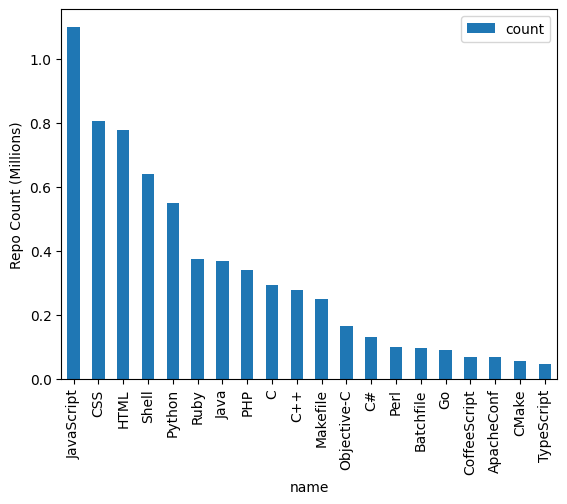

In [42]:
ax = (df.set_index("name") / 1e6).plot.bar()
ax.set_ylabel("Repo Count (Millions)")

In [44]:
# what software licenses are most popular on repos that use Python?
q = bq.query("""
SELECT license, COUNT(*) as count
FROM 
    bigquery-public-data.github_repos.languages,
    UNNEST(languages.language)
    INNER JOIN bigquery-public-data.github_repos.licenses ON languages.repo_name = licenses.repo_name
GROUP BY license
ORDER BY count DESC
LIMIT 20
""", job_config=no_cache)
df = q.to_dataframe()
df.head(3)

,license,count
0,mit,3603080
1,apache-2.0,1180687
2,gpl-2.0,1089260


<Axes: xlabel='license'>

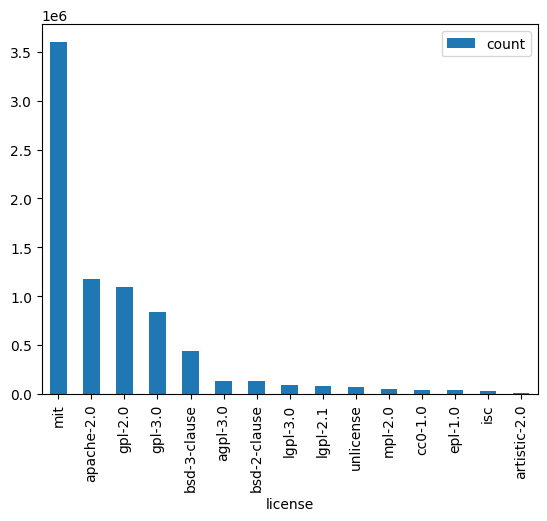

In [46]:
df.set_index("license").plot.bar()

# Data Sources

In [47]:
# gs://apr26/hdma-wi-2021.parquet

In [48]:
# example 1: regular BQ table
config = bigquery.LoadJobConfig(source_format="PARQUET", write_disposition="WRITE_TRUNCATE")
job = bq.load_table_from_uri(["gs://apr26/hdma-wi-2021.parquet"],
                             "cs320-f21.apr28.loans", job_config=config)
job.result()

LoadJob<project=cs320-f21, location=US, id=1d535aec-99e8-433a-96d6-a8f38026b015>

In [49]:
# example 2: external table in Google Cloud Storage
config = bigquery.ExternalConfig("PARQUET")
config.source_uris = ["gs://apr26/hdma-wi-2021.parquet"]
# config.autodetect = True
table = bigquery.Table("cs320-f21.apr28.loans-external")
table.external_data_configuration = config
bq.create_table(table, exists_ok=True)

Table(TableReference(DatasetReference('cs320-f21', 'apr28'), 'loans-external'))

In [ ]:
# https://docs.google.com/spreadsheets/d/1e2qLPyxZ7s5ibMyEg7bxX2wWYAQD2ROAUcZuv8fqhnA/edit#gid=2129344515

In [50]:
# example 3: external table in Google Sheets
config = bigquery.ExternalConfig("GOOGLE_SHEETS")
config.source_uris = ["https://docs.google.com/spreadsheets/d/1e2qLPyxZ7s5ibMyEg7bxX2wWYAQD2ROAUcZuv8fqhnA"]
config.autodetect = True
table = bigquery.Table("cs320-f21.apr28.applications")
table.external_data_configuration = config
bq.create_table(table, exists_ok=True)

Table(TableReference(DatasetReference('cs320-f21', 'apr28'), 'applications'))

In [51]:
%%bigquery
SELECT *
FROM cs320-f21.apr28.applications

Query is running:   0%|          |

Downloading:   0%|          |

,Timestamp,loan_amount,income,latitude,longitude
0,2023-04-18 15:47:56.141000+00:00,200000,75000,43.069610,-89.411429
1,2023-04-18 22:02:45.381000+00:00,500000,125000,43.044469,-89.432674
2,2023-04-19 14:24:42.341000+00:00,350000,80000,44.513755,-88.057333
3,2023-04-20 08:59:51.179000+00:00,190000,150000,43.889848,-91.197627
4,2023-04-25 22:12:49.061000+00:00,250000,25000,43.905450,-89.060410
5,2023-04-25 22:16:03.936000+00:00,1200000,75000,42.711962,-88.639941
6,2023-04-26 17:29:54.788000+00:00,10000000,10000000,43.072125,-89.403310
7,2023-04-27 19:01:46.396000+00:00,10000,1,43.072200,89.400800
8,2023-04-27 20:06:10.639000+00:00,250000,150000,45.111400,87.047100
9,2023-04-27 20:40:45.871000+00:00,200000,150000,45.031929,-87.222494


In [52]:
%%bigquery
SELECT *
FROM cs320-f21.apr28.loans
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,index,state_code,county_code,census_tract,action_taken,loan_amount,interest_rate,loan_term,income,approved
0,25517,WI,None,None,1,125000.0,5.95,180.0,125000.0,True
1,25575,WI,None,None,1,35000.0,5.95,180.0,83000.0,True
2,59936,WI,None,None,2,285000.0,3.79,120.0,525000.0,False
3,59982,WI,None,None,2,135000.0,2.79,120.0,94000.0,False
4,60035,WI,None,None,2,35000.0,6.29,180.0,113000.0,False


In [55]:
%%bigquery
SELECT *
FROM `cs320-f21.apr28.loans-external`
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,index,state_code,county_code,census_tract,action_taken,loan_amount,interest_rate,loan_term,income,approved
0,0,WI,55027,55027961800,6,305000.0,3.875,360.0,108000.0,False
1,1,WI,55001,55001950501,4,65000.0,NaN,360.0,103000.0,False
2,2,WI,55013,55013970400,6,75000.0,3.250,360.0,146000.0,False
3,3,WI,55059,55059002000,1,155000.0,4.000,360.0,70000.0,True
4,4,WI,55087,55087013300,1,305000.0,3.250,360.0,71000.0,True


# Geo Data

In [56]:
# 55 is WI
q = bq.query("""
SELECT county_geom
FROM bigquery-public-data.geo_us_boundaries.counties
WHERE state_fips_code = '55'
""")

In [57]:
df = q.to_geodataframe()

In [58]:
type(df)

geopandas.geodataframe.GeoDataFrame

<Axes: >

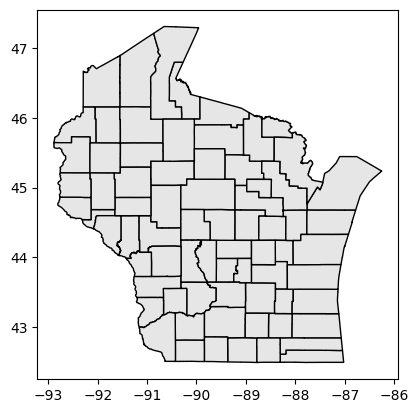

In [61]:
df.plot(edgecolor="k", facecolor="0.9")